# Wide Receiver Career Statistics Analysis
## Goal: To analyze the career statistics of wide receivers in the National Football Leage. All data is scraped from https://www.pro-football-reference.com. This data is scraped and stored in SQLite databases on my computer. 

### The database I put together has wide receivers whose last year was prior to 1994 and wide receivers who have data on Pro football Reference. Many of the players who are not included have negligible statistics or have not played in enough games to have a page on the website that I was able to scrape. Additionally, 1994 was the first year that statistics like first downs and targets were tracked. 

#### Our first step will be to just take a look at the data we have.

In [347]:
from read_from_db import read_all_from_db

In [348]:
df = read_all_from_db(abs_path="/Users/nickblackmore/personal_projects/sportscrape/_database_creation/core/Databases/NFL.db",table="nfl_wrs_1994")

In [349]:
df.drop_duplicates(['Name'], inplace=True) #Preventative measure in case any values were duplicated in the database
df.set_index('Name', inplace=True)
df.drop(['index', 'Lng', 'Y/R', 'R/G', 'Y/G', 'Ctch%', 'Y/Tgt'], axis=1, inplace=True)
df.head()

,GS,Tgt,Rec,Yds,TD,1D,HOF
Name,,,,,,,
Jared Abbrederis,,25,13,163,0,7,No
Charlie Adams,2,40,21,203,0,9,No
Davante Adams,77,665,411,4985,43,242,No
Kris Adams,,8,2,26,0,2,No
James Adkisson,,2,1,9,0,0,No


In [350]:
import seaborn as sns; sns.set(style="ticks", color_codes=True)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [351]:
print(df.dtypes)

GS     object
Tgt    object
Rec    object
Yds    object
TD     object
1D     object
HOF    object
dtype: object


In [352]:
df[df.columns[0:6]] = df[df.columns[0:6]].apply(pd.to_numeric)
print(df.dtypes)

GS     float64
Tgt      int64
Rec      int64
Yds      int64
TD       int64
1D       int64
HOF     object
dtype: object


### Next we will try to visualize the data and see how the variables relate to one another. We will also replace the null values in the "Games Started" column with zeros. Much of the pre-processing of the data was done in the data scraping model, so there will not be as much of that here

/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


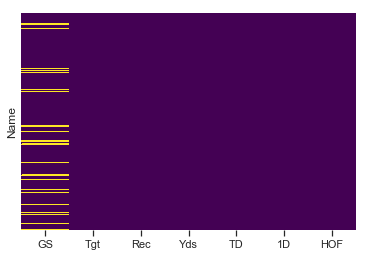

In [353]:
df.where(df != "", None)
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')

In [354]:
df["GS"] = df["GS"].fillna(0)

In [355]:
from sklearn.preprocessing import StandardScaler
#Since the all of the features by definition have different units, the data must be standardized with the unit 
#variance. Otherwise, when we perform PCA, the first principal component would be affected by the 'Yds' column--
#the column with the most variance.

def standardize(dataframe):
    new_df = dataframe.copy()
    new_df[["GS","Tgt","Rec","Yds","TD","1D"]] = StandardScaler().fit_transform(new_df[["GS","Tgt","Rec","Yds","TD","1D"]])
    return new_df

standardized_df = standardize(df)
standardized_df.head()

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,GS,Tgt,Rec,Yds,TD,1D,HOF
Name,,,,,,,
Jared Abbrederis,-0.699720,-0.669444,-0.657969,-0.652064,-0.633184,-0.623624,No
Charlie Adams,-0.655978,-0.627738,-0.622776,-0.639368,-0.633184,-0.609072,No
Davante Adams,0.984362,1.110018,1.092858,0.878430,1.390749,1.086299,No
Kris Adams,-0.699720,-0.716711,-0.706358,-0.695547,-0.633184,-0.660006,No
James Adkisson,-0.699720,-0.733393,-0.710757,-0.700943,-0.633184,-0.674558,No


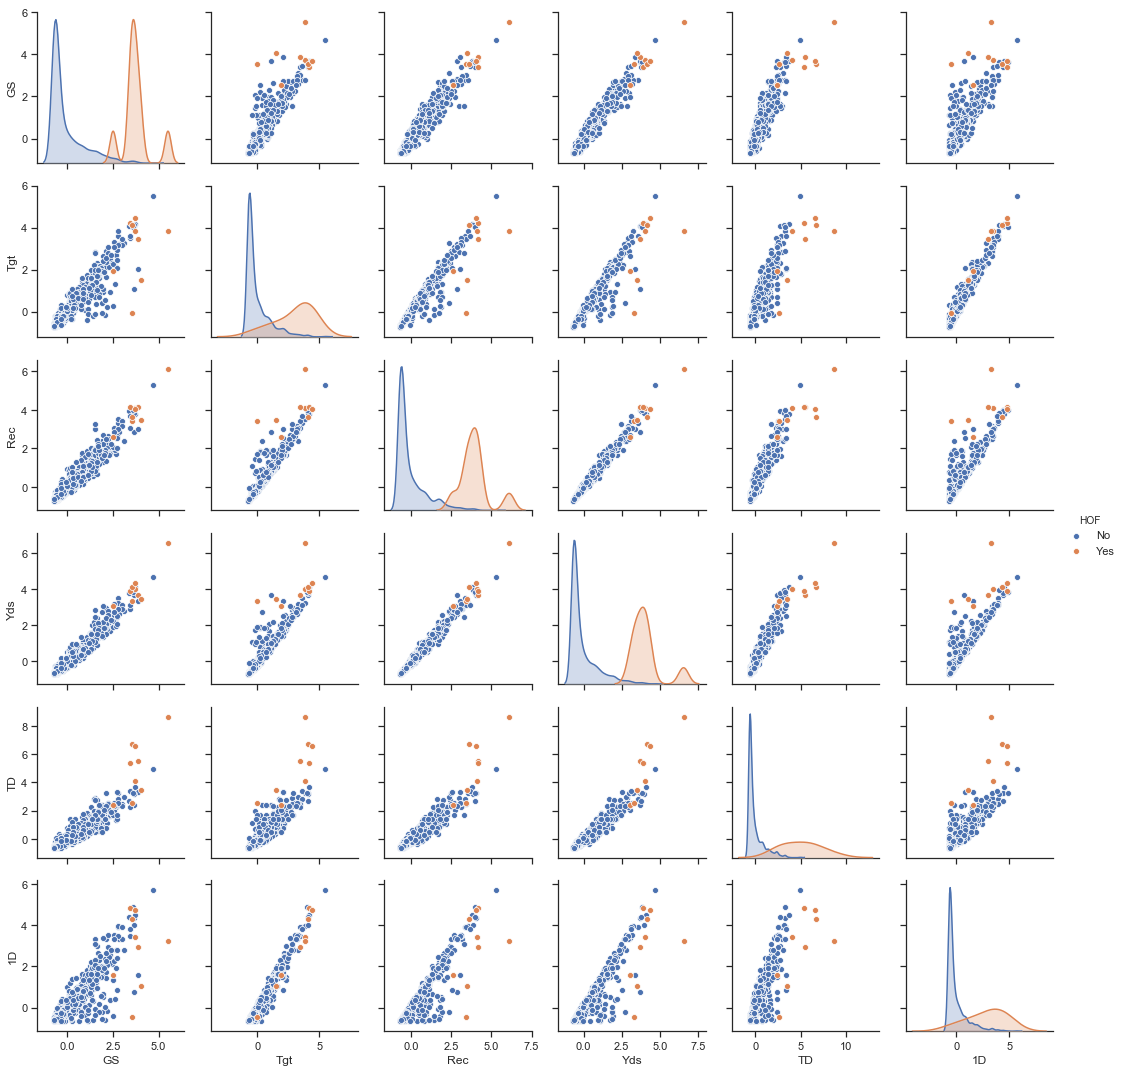

In [356]:
sns.pairplot(standardized_df, hue="HOF")

In [357]:
from sklearn import decomposition

In [358]:
def pca_conversion(dataframe):
    
    X1 = standardized_df[["GS","Tgt","Rec","Yds","TD","1D"]]
    Y1 = list(df["HOF"])

    pca = decomposition.PCA(n_components=2)
    pc = pca.fit_transform(X1)
    pc_df = pd.DataFrame(data = pc, columns=["PC1", 'PC2'], index=dataframe.index)
    pc_df["HOF"] = Y1
    
    return pc_df, pca

pc_df, pca = pca_conversion(standardized_df)
pc_df.head()

,PC1,PC2,HOF
Name,,,
Jared Abbrederis,-1.607072,-0.015029,No
Charlie Adams,-1.546493,-0.019890,No
Davante Adams,2.668258,0.012948,No
Kris Adams,-1.679083,0.013761,No
James Adkisson,-1.695807,0.029006,No


In [359]:
print(pca.explained_variance_ratio_)

[0.95475578 0.02733469]


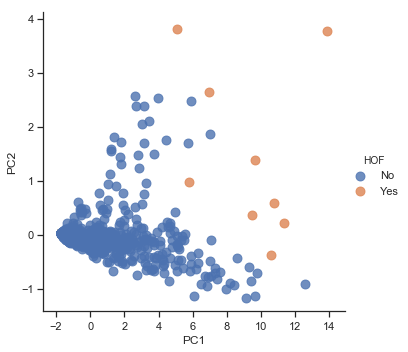

In [360]:
def plot_pca(pca_df):
    return sns.lmplot( x="PC1", y="PC2",
      data=pca_df, 
      fit_reg=False, 
      hue='HOF', 
      legend=True,
      scatter_kws={"s": 80}) 

plot_pca(pc_df)

### We can clearly see from the pairplot that Hall of Fame players have in general higher stats than players that do not. We can also see that while the feautures appear to highly correlated with one another (due to PC1 accounting for 99.8% of the variance in the data) , none of them are normally distributed. Because of this, and because the sample size for the Hall of Fame players is considerable less than that of the non-Hall of Fame players, we will use non-parametric tests to determine how signifcantly every prediction feature differs between Hall of Fame and non-Hall of Fame players.

In [361]:
df["HOF"].value_counts()

No     959
Yes      9
Name: HOF, dtype: int64

### Before we apply any statistical tests or models, we have to address another complication. Some hall of fame caliber players simply haven't been voted into the hall of fame yet because they are either still playing or not enough time has elapsed since the end of their careers for them to be voted in. To work around this, we will change the value in the "HOF" column to "yes" for some of the sure-fire hall of famers that haven't been voted in yet (Larry Fitzgerald, Calvin Johnson, etc.). This of course is subjective and is based on my own predictions of who the "sure-fire" hall of famers are. 

In [362]:
print(df[df['HOF']== 'Yes'])

                    GS   Tgt   Rec    Yds   TD   1D  HOF
Name                                                    
Tim Brown        202.0  1643  1094  14934  100  566  Yes
Cris Carter      209.0  1515  1101  13899  130  499  Yes
Marvin Harrison  188.0  1781  1102  14580  128  756  Yes
Michael Irvin    147.0   960   750  11904   65  309  Yes
Art Monk         194.0   241   940  12721   68   28  Yes
Randy Moss       193.0  1741   982  15292  156  684  Yes
Terrell Owens    201.0  1867  1078  15934  153  747  Yes
Andre Reed       217.0   809   951  13198   87  240  Yes
Jerry Rice       284.0  1640  1549  22895  197  537  Yes


In [363]:
future_hof = ["Larry Fitzgerald", "Calvin Johnson", "Andre Johnson", "Steve Smith", "Isaac Bruce"]
for player in future_hof:
    df.loc[player, "HOF"] = "Yes"
    
print(df[df['HOF']== 'Yes'])


                     GS   Tgt   Rec    Yds   TD   1D  HOF
Name                                                     
Tim Brown         202.0  1643  1094  14934  100  566  Yes
Isaac Bruce       201.0  1770  1024  15208   91  713  Yes
Cris Carter       209.0  1515  1101  13899  130  499  Yes
Larry Fitzgerald  246.0  2249  1370  16990  119  877  Yes
Marvin Harrison   188.0  1781  1102  14580  128  756  Yes
Michael Irvin     147.0   960   750  11904   65  309  Yes
Andre Johnson     187.0  1739  1062  14185   70  701  Yes
Calvin Johnson    130.0  1312   731  11619   83  552  Yes
Art Monk          194.0   241   940  12721   68   28  Yes
Randy Moss        193.0  1741   982  15292  156  684  Yes
Terrell Owens     201.0  1867  1078  15934  153  747  Yes
Andre Reed        217.0   809   951  13198   87  240  Yes
Jerry Rice        284.0  1640  1549  22895  197  537  Yes
Steve Smith       198.0  1748  1031  14731   81  648  Yes


/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


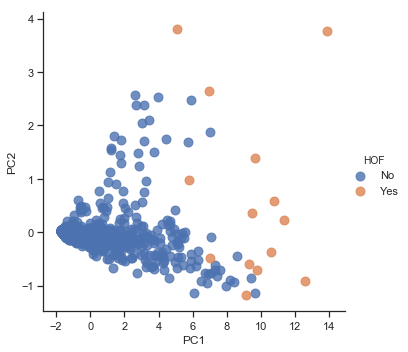

In [364]:
new_standard_df, _ = pca_conversion(standardize(df))
new_standard_df.head()
plot_pca(new_standard_df)

In [365]:
new_standard_df.head()

,PC1,PC2,HOF
Name,,,
Jared Abbrederis,-1.607072,-0.015029,No
Charlie Adams,-1.546493,-0.019890,No
Davante Adams,2.668258,0.012948,No
Kris Adams,-1.679083,0.013761,No
James Adkisson,-1.695807,0.029006,No


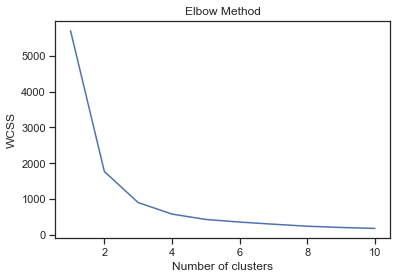

In [323]:
from sklearn.cluster import KMeans

cluster_sum_squares = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(new_standard_df[['PC1', 'PC2']])
    cluster_sum_squares.append(kmeans.inertia_)

plt.plot(range(1, 11), cluster_sum_squares)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Within Cluster Sum of Squares')
plt.show()

### Here we use the elbow method to visualize the "within cluster sum of squares" for different numbers of clusters. We will now train fit the k-means model with three clusters.

In [379]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
output = kmeans.fit(new_standard_df[['PC1', 'PC2']])

kmeans_df = new_standard_df
kmeans_df['cluster_labels'] = output.labels_
kmeans_df['cluster_labels'] =  kmeans_df['cluster_labels'].astype('category')
print(kmeans_df.dtypes)

PC1                float64
PC2                float64
HOF                 object
cluster_labels    category
dtype: object


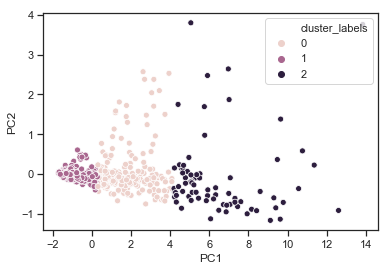

In [383]:
sns.scatterplot(x='PC1', y='PC2', hue="cluster_labels", data=kmeans_df, legend="full")

### As we can see from the clusters, this actually gives us a pretty good idea of the three types of wide recievers based on their career statistics: (Cluster 1) below average players that didn't not play or accumulate very many statistics; (Cluster 0) players that had decent yet un-spectacular careers; and (Cluster 2) players that have above average careers. Below I will compute the percentage of players in each cluster that were elected into the hall of fame. 